# 6. UE-Side: Channel Estimation and Equalization for SSB-PBCH in 5G Networks

The objective of the wireless communication system is to decode the transmitted data at the receiver. Before decoding the data, the receiver must estimate the channel between the transmitter and itself. However, wireless channels are dynamic and subject to various environmental factors such as multipath fading, shadowing, and interference. By accurately estimating the wireless channel, the receiver can decode the transmitted data without any error . Error-free decoding of data results in higher throughput and lower BLER, thus making accurate channel estimation in wireless communication crucial. In this experiment, we will discuss different techniques for channel estimation and use this estimated channel to decode the SSB.

## 6.2 Import Libraries
### 6.2 Import Python and SDR Libraries

In [1]:

# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import matplotlib.animation as animation


### 6.2 Import 5G Toolkit Libraries 

In [2]:

import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualizationPBCH, DMRSParameterDetection, CarrierFrequencyOffsetEstimation
from toolkit5G.OFDM               import OFDMDemodulator
from toolkit5G.PhysicalChannels   import PBCHDecoder


## 6.2 Emulation Parameters

In [3]:

# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 10*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 30000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1

# number of samples returned per call to rx()
buffer_size         = int(4*fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 6.2 Time-frequency Parameter

In [4]:

nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length


## 6.2 SDR Setup

In [5]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.3.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Rx
sdr.rx_lo                   = int(center_frequency) # Sets the receiver local oscillator frequency. 
# For Pluto SDR, rx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.rx_rf_bandwidth         = int(60*10**6)         # Set the bandwidth (in Hz) of the reception filter
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.rx_buffer_size          = int(buffer_size)      # Number of samples to read and load into SDR buffer.
# The upper limit on the size of this buffer is defined by the DRAM size.

sdr.gain_control_mode_chan0 = 'slow_attack'              # Defines the mode of receiver AGC.
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.rx_hardwaregain_chan0   = 40.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC
# Sets the amplification gain (dB) provided by the low noise amplifier (LNA). 
# Relevant only when `gain_control_mode_chan0` is "manual".


## 6.2 Receive Samples from SDR

In [6]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()
# Receive samples
rx_samples = sdr.rx()


## 6.2 Time Synchronization: Coarse Tuning

**(rasterOffset, PSS-ID) (368, 0)
**(rasterOffset, PSS-ID) (368, 1)
**(rasterOffset, PSS-ID) (368, 2)


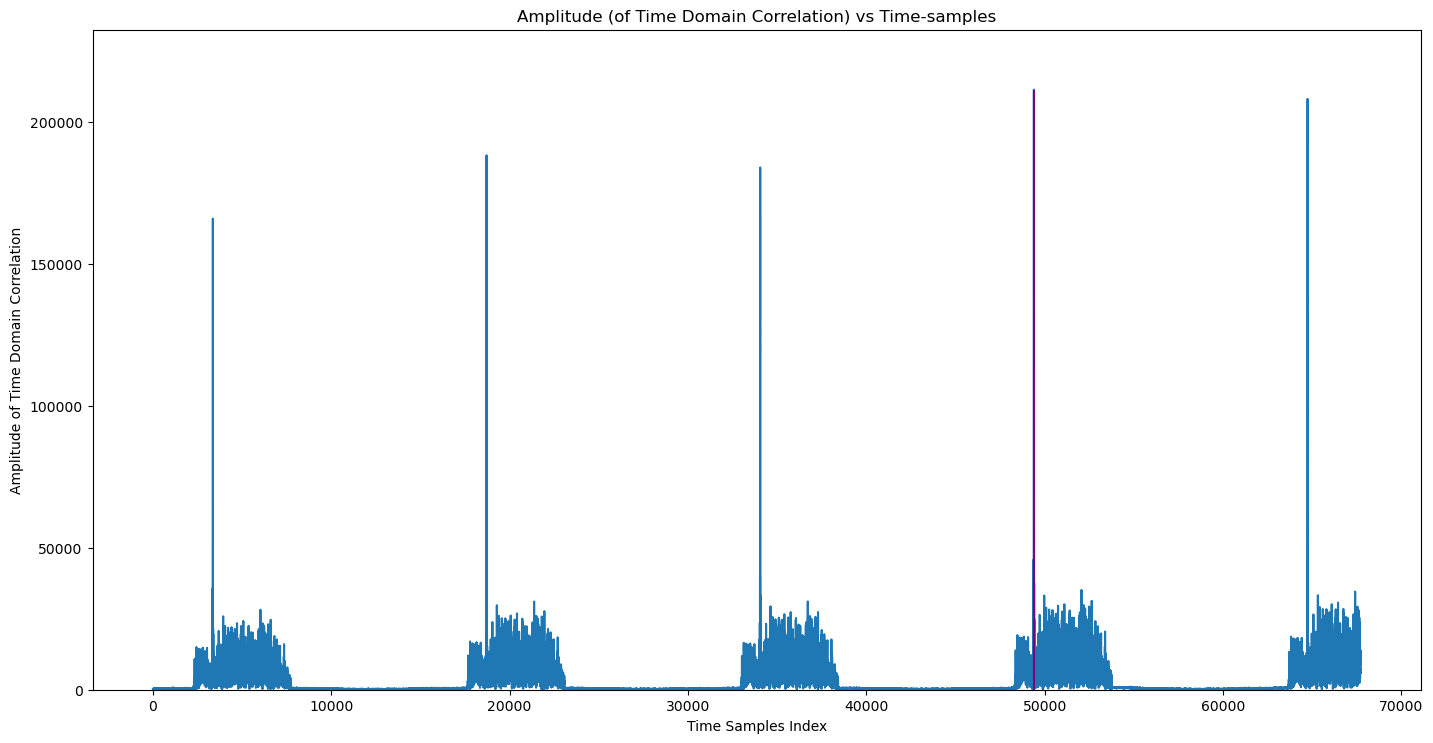

In [7]:

## PSS Detection: Based on time domain PSS Correlation

numofGuardCarriers = (int((tfParams.fftsize - Neff)/2), int((tfParams.fftsize + Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int(numofGuardCarriers[0]+offsetToPointA)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  nID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
scaleFig = 1.75
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()


## 6.2 CFO Estimation

In [8]:

## Parameters for computing CFO
cyclic_prefix_length      = lengthCP[1]    # Length of cyclic prefix
numSamples                = fftSize + cyclic_prefix_length   # OFDM samples of 1 symbol
firstIndex                = pssPeakIndices   # PSS detection
pssOfdmSymbols            = rx_samples[firstIndex: firstIndex + numSamples] # PSS samples

obj    = CarrierFrequencyOffsetEstimation(fftSize,cyclic_prefix_length)
cfoEst = obj(pssOfdmSymbols,numCFOIteration = 2)  # Computed CFO


## 6.2 OFDM Demodulation

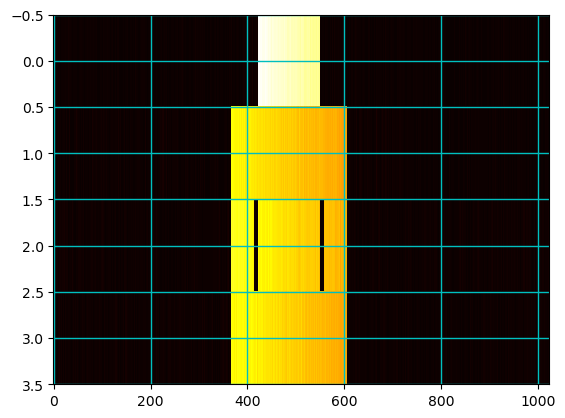

The Estimated CFO is 0.4767798191431972


In [9]:

## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices
indices         = np.arange(rx_samples.size)

# With CFO correction
cfo             = cfoEst
rxGrid          = ofdmDemodulator(((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])
ssbEstimate     = rxGrid[:,:,ssboffset:(ssboffset+240)]

# Plot Received Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()
print("The Estimated CFO is " +str(cfo))


## 6.2 Extract SSB Grid

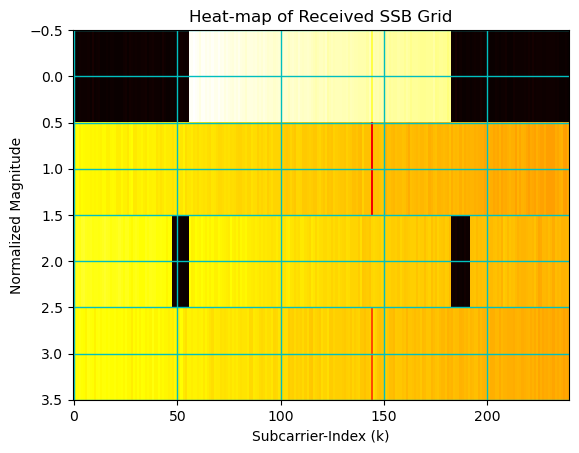

In [10]:

## Plot SSB
fig, ax = plt.subplots()
ax.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received SSB Grid")
plt.show()


## 6.2 SSS and DMRS Parameter Detection

* SSS Detection
* PBCH Parameter Estimation

In [11]:

## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2    # Estimating Physical cell-ID.

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices   # Indices of PBCH DMRS.

## Generate DMRS sequence
nssbCandidatesInHrf = 4
dmrsLen             = 144  # Length of DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen) # DMRS sequence.


## 6.2 Channel Estimation and PBCH Symbol Equalization

PBCH supports following:
- **Channel Estimation schemes**:
    - Zero-forcing: "ZF"
    - Minimum mean sequare estimation: "MMSE"
- **Channel interpolation schemes**:
    - Nearest neighbour: "NN"
    - Linear: "Linear"
    - Spline: "Spline" of any order (3,5,7,9,......)

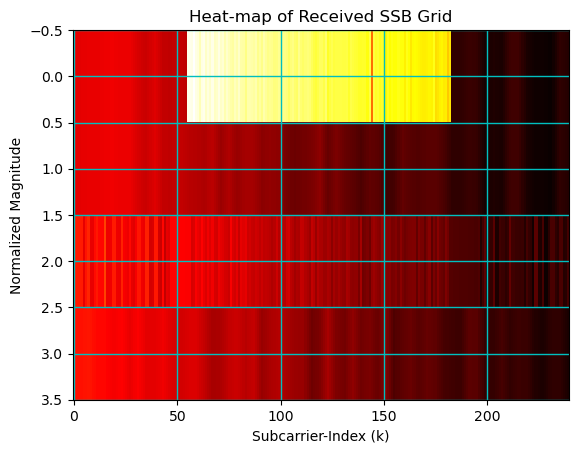

In [12]:

# ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
# ## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
pbchEstimate   = chanEst(ssbEstimate[0], rxDMRSseq, rN_ID)

## Plot SSB
fig, ax = plt.subplots()
ax.imshow(np.abs(chanEst.channelEstimates[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received SSB Grid")
plt.show()


In [13]:
chanEst.channelEstimates[0].shape

(4, 240)

## 6.2 PBCH Decoding

In [14]:

## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "app"
extractMIBinfo = True
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, 
                             rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)


<frozen toolkit5G.ChannelCoder.PolarCoder.polarDecoder>:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.


## 6.2 Constellation Diagram: UE

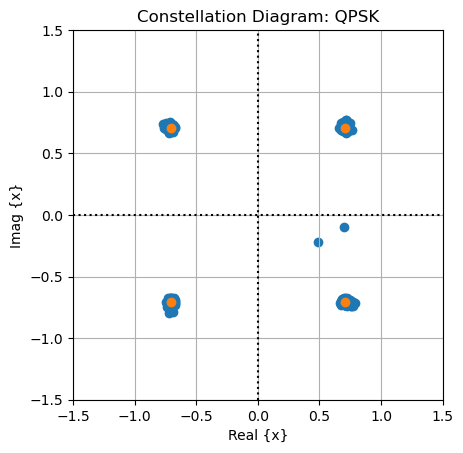

In [15]:

qpsk = np.array([1+1j, 1-1j, -1+1j, -1-1j])/np.sqrt(2)
fig, ax = plt.subplots()
ax.set_aspect(True)
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
ax.scatter(np.real(qpsk), np.imag(qpsk), )
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()


## 6.2 Checking whether CRC is correct

In [16]:
check

array([[ True]])

## 6.2 Quasi-realtime: CFO Estimation and Reconstruction

``Note``: The following snippet of code only works with interactive maplotlib.

1. ![caution6-3](caution.jpg) **Please ensure that you have intractive matplotlib installed on your system.**
2. **uncomment the ``%matplotlib widget`` in first code block for the following section of code to work**

In [17]:
# function that draws each frame of the animation
def animate(i):
    # Receive samples
    rx_samples = sdr.rx()
    
    pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)
    
    if(pssPeakIndices < 3*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices + 14*(fftSize + lengthCP[1])
    elif(pssPeakIndices > rx_samples.size - 13*(fftSize + lengthCP[1])):
        pssPeakIndices = pssPeakIndices - 14*(fftSize + lengthCP[1])

    # CFO estimation
    obj    = CarrierFrequencyOffsetEstimation(fftSize,lengthCP[1])
    cfoEst = obj(rx_samples[pssPeakIndices: pssPeakIndices + numSamples],numCFOIteration = 2)  # Computed CFO
    
    ## OFDM Demodulator Object
    ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
    pssStartIndex   = pssPeakIndices

    # With CFO correction
    cfo             = cfoEst
    rxGrid          = ofdmDemodulator(((np.exp(-1j*cfoEst*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])
    ssbEstimate     = rxGrid[:,:,ssboffset:(ssboffset+240)]

    chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "NN", isUEmobile=True)
    pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

    ## PBCH Chain for Decoding information
    # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
    pbchDecoder     = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
    rxMIB, check    = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

    ax[0].clear()
    ax[0].set_xlim([-1.5, 1.5])
    ax[0].set_ylim([-1.5, 1.5])
    ax[0].scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
    ax[0].scatter(np.real(qpsk), np.imag(qpsk), )
    ax[0].grid()
    ax[0].axhline(y=0, ls=":", c="k")
    ax[0].axvline(x=0, ls=":", c="k")
    ax[0].set_xlabel("Real {x}")
    ax[0].set_ylabel("Imag {x}")
    ax[0].set_title("Constellation Diagram | NN")
    
    chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile=True)
    pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

    ## PBCH Chain for Decoding information
    # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
    pbchDecoder     = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
    rxMIB, check    = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

    ax[1].clear()
    ax[1].set_xlim([-1.5, 1.5])
    ax[1].set_ylim([-1.5, 1.5])
    ax[1].scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
    ax[1].scatter(np.real(qpsk), np.imag(qpsk), )
    ax[1].grid()
    ax[1].axhline(y=0, ls=":", c="k")
    ax[1].axvline(x=0, ls=":", c="k")
    ax[1].set_xlabel("Real {x}")
    ax[1].set_ylabel("Imag {x}")
    ax[1].set_title("Constellation Diagram | Linear")
    
    chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Spline", isUEmobile=True)
    pbchEstimate   = chanEst(ssbEstimate, rxDMRSseq, rN_ID)

    ## PBCH Chain for Decoding information
    # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
    pbchDecoder     = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
    rxMIB, check    = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

    ax[2].clear()
    ax[2].set_xlim([-1.5, 1.5])
    ax[2].set_ylim([-1.5, 1.5])
    ax[2].scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
    ax[2].scatter(np.real(qpsk), np.imag(qpsk), )
    ax[2].grid()
    ax[2].axhline(y=0, ls=":", c="k")
    ax[2].axvline(x=0, ls=":", c="k")
    ax[2].set_xlabel("Real {x}")
    ax[2].set_ylabel("Imag {x}")
    ax[2].set_title("Constellation Diagram | Spline")
    

# Plot SSB
fig, ax = plt.subplots(1,3, figsize = (10,3))
ax[0].set_aspect(True)
ax[1].set_aspect(True)
ax[2].set_aspect(True)

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.

anim = animation.FuncAnimation(fig, animate, frames=1000, interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

anim.save("Channel_Estimation_RT2.gif", fps = 10)

# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save('Overall.mp4', writer=writervideo)

![Channel_Estimation_RT2](Channel_Estimation_RT2.gif)